# Accessing STAC catalog - example for GeoParquet data

This notebook demonstrates how to access and explore Parquet data.
In this tutorial you will learn:  
- how to access and GeoParquet vector data from a STAC catalog and subset it to an area of interest.
- how to visualize the different elements of the vector dataset on an interactive map.

This tutorial uses the [dataset of critical infrastructure](https://www.openearth.nl/coclico-workbench/Datasets/#__tabbed_5_3) from the CoCliCo STAC Catalog as an example.

## Preparation steps

### Load libraries

In [1]:
import os
import numpy as np
import geopandas as gpd
import dask_geopandas as dgpd
import pystac
import shapely
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import fsspec
import json

We will make plots using plotly. By default this will result in interactive plots when executing the notebook locally, but this can also result in large file size for the jupyter notebook. We will save the name of the default (automatically-selected) renderer, to be able to switch between renderers later (see visualization at the end of the notebook).

In [2]:
plotly_default_renderer = pio.renderers.default

## Access the GeoParquet dataset via the STAC catalog

In this example we use the CoCliCo STAC catalog:

In [3]:
catalog_path = "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
catalog = pystac.Catalog.from_file(catalog_path)

In this example we will access the dataset of critical infrastructure, stored in the STAC catalog under id `ceed_maps` (see the [STAC catalog browser](https://www.openearth.nl/coclico-workbench/data_catalog/) for an overview).

In [4]:
collection_id = 'ceed_maps'

We can check whether the selected collection is available and print its metadata as follows:

In [5]:
collection = catalog.get_child(collection_id)

if collection is None:
    print('Collection not found, check if the name is correct.')
else:
    print(f"ID: {collection.id}")
    print(f"Title: {collection.title or 'N/A'}")
    print(f"Description: {collection.description or 'N/A'}")

ID: ceed_maps
Title: Critical Infrastructure
Description: **Critical infrastructure** represents EU-wide high-resolution object-based maps of economic assets and infrastructure systems in coastal flood-prone areas. Grey polygons represent buildings of any kind, blue lines indicate line elements like roads, railways or powerlines and red dots show objects related to for instance power or telecom. 

- **Spatial coverage**: Coastal LAU (municipality level) 
- **Sources**: Satellite imagery and opensource databases (OpenStreetMap among others)
- **Common usage**: Supports building exposure assessments, informs coastal resilience and adaptation planning, engages stakeholders with accessible data, and helps prioritize investments and strategic land-use decisions.

More Info about the dataset: <a href='https://www.openearth.nl/coclico-workbench/Datasets' target='_blank' rel='noopener noreferrer'>User Handbook</a>


We can verify that this dataset is stored as a GeoParquet:

In [6]:
extents_uri = collection.assets["geoparquet-stac-items"].href
extents_uri

'gs://coclico-data-public/coclico/items/ceed_maps.parquet'

We will retrieve an overview of the features available in this dataset as a geodataframe:

In [7]:
sas_token = os.getenv("AZURE_STORAGE_SAS_TOKEN")
account_name = "coclico"
storage_options = {"account_name": account_name, "credential": sas_token}

In [8]:
with fsspec.open(extents_uri, **storage_options) as f:
    extents = gpd.read_parquet(f)
extents["href"] = extents.assets.map(lambda x: x["data"]["href"])

In [9]:
print(f'Dataset contains {len(extents)} features')

Dataset contains 11085 features


In [10]:
extents.head()

,type,stac_version,stac_extensions,id,geometry,bbox,links,assets,collection,title,description,table:columns,proj:bbox,proj:epsg,table:row_count,created,datetime,href
0,Feature,1.0.0,[https://stac-extensions.github.io/table/v1.2....,AL_AL121,"POLYGON ((19.77478 41.17451, 19.77478 41.58245...","[19.381957567132115, 41.17450808551291, 19.774...","[{'href': None, 'rel': 'root', 'title': 'Criti...",{'data': {'description': 'EU-wide high-resolut...,ceed_maps,CI_data,EU-wide high-resolution object-based maps of e...,"[{'description': '', 'name': 'type', 'type': '...","[5108933.150249555, 2060765.5993253095, 513718...",3035,47323,2025-04-08 09:19:38.179472+00:00,2021-08-01 00:00:00+00:00,gs://coclico-data-public/coclico/LAU_ceed/AL_A...
1,Feature,1.0.0,[https://stac-extensions.github.io/table/v1.2....,AL_AL122,"POLYGON ((20.05234 41.33547, 20.05234 42.28453...","[19.528608668551943, 41.335466296295, 20.05233...","[{'href': None, 'rel': 'root', 'title': 'Criti...",{'data': {'description': 'EU-wide high-resolut...,ceed_maps,CI_data,EU-wide high-resolution object-based maps of e...,"[{'description': '', 'name': 'type', 'type': '...","[5119048.271852754, 2080499.9854660921, 515067...",3035,5364,2025-04-08 09:19:38.989216+00:00,2021-08-01 00:00:00+00:00,gs://coclico-data-public/coclico/LAU_ceed/AL_A...
2,Feature,1.0.0,[https://stac-extensions.github.io/table/v1.2....,AL_AL123,"POLYGON ((19.76243 41.26314, 19.76243 41.49652...","[19.482965546317967, 41.26314196705378, 19.762...","[{'href': None, 'rel': 'root', 'title': 'Criti...",{'data': {'description': 'EU-wide high-resolut...,ceed_maps,CI_data,EU-wide high-resolution object-based maps of e...,"[{'description': '', 'name': 'type', 'type': '...","[5116338.174841609, 2070659.9490308687, 513718...",3035,6363,2025-04-08 09:19:39.871855+00:00,2021-08-01 00:00:00+00:00,gs://coclico-data-public/coclico/LAU_ceed/AL_A...
3,Feature,1.0.0,[https://stac-extensions.github.io/table/v1.2....,AL_AL141,"POLYGON ((20.05234 41.33547, 20.05234 42.28453...","[19.528608668551943, 41.335466296295, 20.05233...","[{'href': None, 'rel': 'root', 'title': 'Criti...",{'data': {'description': 'EU-wide high-resolut...,ceed_maps,CI_data,EU-wide high-resolution object-based maps of e...,"[{'description': '', 'name': 'type', 'type': '...","[5119048.271852754, 2080499.9854660921, 515067...",3035,7756,2025-04-08 09:19:40.745862+00:00,2021-08-01 00:00:00+00:00,gs://coclico-data-public/coclico/LAU_ceed/AL_A...
4,Feature,1.0.0,[https://stac-extensions.github.io/table/v1.2....,AL_AL142,"POLYGON ((19.99052 41.34416, 19.99052 42.49174...","[19.045815769475663, 41.34415728068292, 19.990...","[{'href': None, 'rel': 'root', 'title': 'Criti...",{'data': {'description': 'EU-wide high-resolut...,ceed_maps,CI_data,EU-wide high-resolution object-based maps of e...,"[{'description': '', 'name': 'type', 'type': '...","[5078285.110028214, 2080499.9854660921, 514328...",3035,3957,2025-04-08 09:19:41.490875+00:00,2021-08-01 00:00:00+00:00,gs://coclico-data-public/coclico/LAU_ceed/AL_A...


## Subset and visualize the GeoParquet dataset

To visualize a part of this dataset for an area of interest, we will first define the area of interest as a simple bounding box. The coordinates of a bounding box can be easily generated using the [Bounding Box Tool](https://boundingbox.klokantech.com/) (use .csv format for coordinates):

In [11]:
bbox = [4.344636,51.994851,4.378839,52.019551] 

We can convert the bounding box coordinates to a shapely bounding box variable `area_of interest` and a geodataframe `roi`, these formats are useful in subsetting and visualizing the dataset:

In [12]:
area_of_interest = shapely.geometry.box(*bbox)
roi = gpd.GeoDataFrame(
    geometry=[area_of_interest], crs=4326
)

### Subset the dataset and retrieve features

We can check how many GeoParquet tiles are intersecting with our area of interest:

In [13]:
hrefs = gpd.sjoin(extents, roi).href.to_list()
print(f'Number of dataset features intersecting with the area of interest: {len(hrefs)}')

Number of dataset features intersecting with the area of interest: 9


We can also view a sample of the reference links to these features:

In [14]:
hrefs[:5]

['gs://coclico-data-public/coclico/LAU_ceed/NL_GM0503.parquet',
 'gs://coclico-data-public/coclico/LAU_ceed/NL_GM0518.parquet',
 'gs://coclico-data-public/coclico/LAU_ceed/NL_GM0599.parquet',
 'gs://coclico-data-public/coclico/LAU_ceed/NL_GM0603.parquet',
 'gs://coclico-data-public/coclico/LAU_ceed/NL_GM1621.parquet']

We can now load items from these features, intersecting with the area of interest, into a geodataframe dataset `ci_gdf`:

In [15]:
ci_gdf = dgpd.read_parquet(hrefs, storage_options=storage_options)
ci_gdf = (
    ci_gdf.sjoin(roi.to_crs(ci_gdf.crs)).drop(columns=["index_right"]).compute()
)

The original dataset is provided in projected coordinates. We will convert it to WGS84 coordinates:

In [16]:
ci_gdf = ci_gdf.to_crs("EPSG:4326")

The dataset contains a large number of items, along with the type classification:

In [17]:
print(f'Found items: {len(ci_gdf)}')
ci_gdf.head()

Found items: 16899


,type,geometry
9326,buildings,"POLYGON ((4.36265 51.99429, 4.36265 51.99429, ..."
9342,buildings,"POLYGON ((4.36291 51.99497, 4.36291 51.99497, ..."
9343,buildings,"POLYGON ((4.36291 51.99497, 4.36291 51.99497, ..."
9344,buildings,"POLYGON ((4.36535 51.99568, 4.36535 51.99568, ..."
9345,buildings,"POLYGON ((4.36652 51.99624, 4.36652 51.99624, ..."


We can print an overview of a number of items per infrastructure type:

In [18]:
print(ci_gdf['type'].value_counts())

type
buildings     15638
water           487
road            347
rail            157
education       118
power            99
telecom          37
healthcare       14
oil               2
Name: count, dtype: int64


### Visualizing features on an interactive map

For visualization purposes, it also useful to know what types of geometries are stored for the different types of infrastructure. We can print this overview as follows:

In [19]:
ci_gdf["geom_type"] = ci_gdf.geometry.geom_type

# Group by infrastructure type and geometry type, then count rows
overview = (
    ci_gdf.groupby(["type", "geom_type"])
       .size()
       .reset_index(name="count")
)
print(overview)

          type     geom_type  count
0    buildings       Polygon  15638
1    education  MultiPolygon     85
2    education         Point     33
3   healthcare  MultiPolygon      2
4   healthcare         Point     12
5          oil         Point      2
6        power    LineString      2
7        power  MultiPolygon     28
8        power         Point     69
9         rail    LineString     81
10        rail  MultiPolygon     19
11        rail         Point     57
12        road    LineString    347
13     telecom         Point     37
14       water  MultiPolygon      1
15       water         Point    486


Given the large number of items, it is easier to visualize specific categories we are interested in. In this example we will select `buildings` and `rail` infrastructure to visualize, which contain data in the form of Points, Polygons, MultiPolygons and LineStrings.

In [20]:
types_selected = ["buildings", 'rail']

In [21]:
ci_filtered = ci_gdf[ci_gdf["type"].isin(types_selected)]
print(f'Number of geometric elements in the selection: {len(ci_filtered)}')

Number of geometric elements in the selection: 15795


We can either make an interactive plot (allowing zooming-in and hovering over the item types) or a static plot. The former allows for exploring the data more in detail, while the latter results in smallest memory use and file size. You can switch between these two options in the cell below:

In [22]:
#plotly_renderer = plotly_default_renderer
plotly_renderer = 'png'

Now we can create a plot to visualize the data:

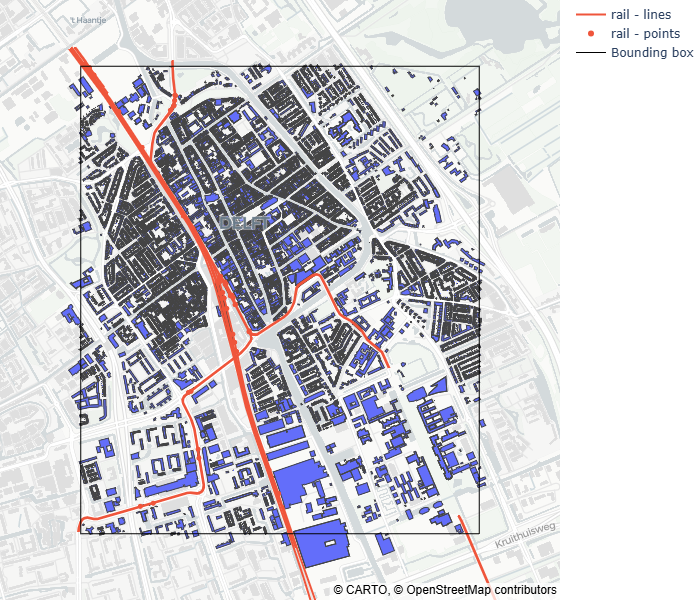

In [23]:
colors = px.colors.qualitative.Plotly

fig = go.Figure()

for tt, type in enumerate(ci_filtered['type'].unique()):

    lats = []
    lons = []
    for linestring in ci_filtered[ci_filtered['type']==type].loc[ci_filtered.geom_type=='LineString'].geometry:
            x, y = linestring.xy
            lats = np.append(lats, y)
            lons = np.append(lons, x)
            lats = np.append(lats, None)
            lons = np.append(lons, None)

    # Plot linestrings
    trace = fig.add_trace(go.Scattermap(
        lon=lons,
        lat=lats,
        mode='lines',
        line=dict(color=colors[tt]), 
        name=f'{type} - lines',
        hoverinfo='text',
        hovertext=type))
    
    # Plot points
    fig.add_trace(go.Scattermap(
        lon=ci_filtered[ci_filtered['type']==type].loc[ci_filtered.geom_type=='Point'].geometry.x,
        lat=ci_filtered[ci_filtered['type']==type].loc[ci_filtered.geom_type=='Point'].geometry.y,
        mode='markers',
        marker=dict(color=colors[tt]), 
        name=f'{type} - points',
        hoverinfo='text',
        hovertext=type,
        ))
    
    # Plot polygons
    polygons = ci_filtered[ci_filtered['type']==type].loc[ci_filtered.geometry.type.isin(['Polygon','MultiPolygon'])]
    geojson = json.loads(polygons.to_json())
    fig.add_trace(go.Choroplethmap(
        geojson=geojson,
        locations=polygons.index,
        z=np.ones(len(polygons)),
        colorscale=[[0, colors[tt]], [1, colors[tt]]],
        text=polygons['type'],
        name='polygons',
        showscale=False,
        hovertemplate='<b>%{text}</b><extra></extra>',
    ))

bbox_lon, bbox_lat = area_of_interest.exterior.coords.xy
fig.add_trace(go.Scattermap(
    lon=list(bbox_lon),
    lat=list(bbox_lat),
    mode="lines",
    line=dict(color="black", width=1),
    name="Bounding box",
    showlegend=True
))

# # Update layout
fig.update_layout(
    map=dict(
        style="carto-positron",
        center={"lat": area_of_interest.centroid.y,
                "lon": area_of_interest.centroid.x},
        zoom=13,
    ),
    height=600,
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=True
)

fig.show(renderer=plotly_renderer)

## References

[Critical infrastructure dataset, CoCliCo STAC catalog - methodology](https://www.openearth.nl/coclico-workbench/Datasets/#__tabbed_5_3)

## Contributors

Natalia Aleksandrova, Deltares